In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline

In [35]:
# Loading the CSV file
df = pd.read_csv('../exact_curve/exact_curve.csv')

# Calculating the Total Energy
df['TE'] = df['NRE'] + df['EE']
print(df.loc[df['TE'].idxmin(), 'BL'])

0.9900000000000004


In [36]:
# Read data from selected.csv file
selected_df = pd.read_csv('selected.csv')

# Extract BL column as the list of highlight points
highlight_BL = selected_df['BL'].tolist()

# Lists to store interpolated highlight points
highlight_points_BL = []
highlight_points_TE = []

# Iterate over each BL value to be highlighted
for bl in highlight_BL:
    # If BL exists in df, directly get the corresponding TE
    if bl in df['BL'].values:
        te = df.loc[df['BL'] == bl, 'TE'].values[0]
        highlight_points_BL.append(bl)
        highlight_points_TE.append(te)
    else:
        # If BL does not exist in df, find neighboring points for interpolation
        df_sorted = df.sort_values(by='BL')  # Ensure BL is sorted
        lower_idx = np.searchsorted(df_sorted['BL'], bl) - 1
        upper_idx = lower_idx + 1

        # Get neighboring BL and TE values
        if lower_idx >= 0 and upper_idx < len(df_sorted):
            bl_lower = df_sorted.iloc[lower_idx]['BL']
            bl_upper = df_sorted.iloc[upper_idx]['BL']
            te_lower = df_sorted.iloc[lower_idx]['TE']
            te_upper = df_sorted.iloc[upper_idx]['TE']

            # Perform linear interpolation
            te = te_lower + (te_upper - te_lower) * (bl - bl_lower) / (bl_upper - bl_lower)
            highlight_points_BL.append(bl)
            highlight_points_TE.append(te)

# Define error bounds
# naive_fixed_shots error bound
error_bound_1 = 0.02 
highlight_points_TE_1 = [x + error_bound_1 for x in highlight_points_TE]

# Bayesian IQAE error bound
error_bound_2 = 0.001
highlight_points_TE_2 = [x + error_bound_2 for x in highlight_points_TE]


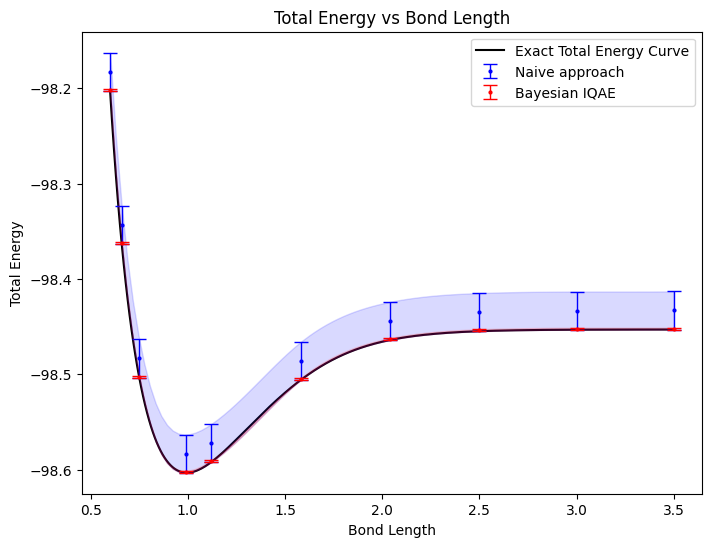

In [37]:
# Plot data
plt.figure(figsize=(8, 6))
plt.plot(df['BL'], df['TE'], marker='o', linestyle='-', markersize=0, color='black',
         label='Exact Total Energy Curve', zorder=1)  # Black line at the bottom layer

# Plot error bars in blue to show error bounds
plt.errorbar(highlight_points_BL, highlight_points_TE_1, yerr=error_bound_1, fmt='o', color='blue',
             ecolor='blue', elinewidth=1, capsize=5, markersize=2, zorder=2, label='Naive approach')  # Blue layer in the middle

# Perform spline interpolation on blue highlight points
highlight_points_BL_sorted, highlight_points_TE_1_sorted = zip(*sorted(zip(highlight_points_BL, highlight_points_TE_1)))
spline_blue = make_interp_spline(highlight_points_BL_sorted, highlight_points_TE_1_sorted)
BL_smooth = np.linspace(min(highlight_points_BL_sorted), max(highlight_points_BL_sorted), 100)
TE_smooth_blue = spline_blue(BL_smooth)

# Fill shaded error area for blue error bounds
plt.fill_between(BL_smooth, TE_smooth_blue - error_bound_1, TE_smooth_blue + error_bound_1,
                 color='blue', alpha=0.15, zorder=2)  # Blue shaded area in the middle layer

# Plot error bars in red to show error bounds
plt.errorbar(highlight_points_BL, highlight_points_TE_2, yerr=error_bound_2, fmt='o', color='red',
             ecolor='red', elinewidth=1, capsize=5, markersize=2, zorder=3, label='Bayesian IQAE')  # Red layer on top

# Perform spline interpolation on red highlight points
highlight_points_BL_sorted, highlight_points_TE_2_sorted = zip(*sorted(zip(highlight_points_BL, highlight_points_TE_2)))
spline_red = make_interp_spline(highlight_points_BL_sorted, highlight_points_TE_2_sorted)
TE_smooth_red = spline_red(BL_smooth)

# Fill shaded error area for red error bounds
plt.fill_between(BL_smooth, TE_smooth_red - error_bound_2, TE_smooth_red + error_bound_2,
                 color='red', alpha=0.15, zorder=3)  # Red shaded area on top layer

# Set chart labels and title
plt.xlabel('Bond Length')
plt.ylabel('Total Energy')
plt.title('Total Energy vs Bond Length')
plt.legend()
plt.savefig('total_energy_curve.png', dpi=300, bbox_inches='tight')  # Save figure with dpi and tight bounding box
plt.show()
